A. Import Modules

In [2]:
import h2o
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
#import xgboost as xgb
h2o.init() # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,1 day 5 hours 55 mins
H2O cluster version:,3.10.5.2
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_Soomin_xyvaej
H2O cluster total nodes:,1
H2O cluster free memory:,737 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


B. Import Data & Create Sales Price Dummy Column in Test Dataset

In [7]:
train = h2o.import_file('train.csv')
test = h2o.import_file('test.csv')

dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 81)


C. Determine Data Types

In [8]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [9]:
original_nums, original_cats = get_type_lists()

Numeric = ['LowQualFinSF', 'BedroomAbvGr', 'OverallCond', 'ScreenPorch', 'YearBuilt', 'EnclosedPorch', 'BsmtFinSF1', 'KitchenAbvGr', 'MoSold', 'BsmtHalfBath', 'OverallQual', 'OpenPorchSF', 'BsmtFinSF2', 'GrLivArea', 'FullBath', '2ndFlrSF', 'GarageCars', 'BsmtUnfSF', 'LotFrontage', 'TotalBsmtSF', 'YrSold', 'MSSubClass', 'PoolArea', 'WoodDeckSF', 'TotRmsAbvGrd', 'HalfBath', '1stFlrSF', 'GarageArea', 'MiscVal', 'Fireplaces', 'LotArea', 'BsmtFullBath', 'GarageYrBlt', 'YearRemodAdd', 'MasVnrArea', '3SsnPorch']

Categorical = ['GarageQual', 'GarageFinish', 'HouseStyle', 'Utilities', 'Exterior2nd', 'Fence', 'Alley', 'ExterCond', 'BsmtExposure', 'LotShape', 'GarageCond', 'CentralAir', 'LandSlope', 'SaleCondition', 'BsmtFinType2', 'PavedDrive', 'LotConfig', 'FireplaceQu', 'Street', 'Functional', 'BsmtCond', 'PoolQC', 'Neighborhood', 'BldgType', 'ExterQual', 'Exterior1st', 'BsmtQual', 'MSZoning', 'Condition1', 'RoofStyle', 'BsmtFinType1', 'RoofMatl', 'GarageType', 'MiscFeature', 'Foundation', 'L

In [10]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


D. Impute Missing Values and Feature Engineer Categorical Variables

In [11]:
pandas_train = train.as_data_frame(use_pandas=True) #Convert to Pandas frame
pandas_train.isnull().any() #Check for missing values (TRUE = missing)

Id               False
MSSubClass       False
MSZoning         False
LotFrontage       True
LotArea          False
Street           False
Alley             True
LotShape         False
LandContour      False
Utilities        False
LotConfig        False
LandSlope        False
Neighborhood     False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
RoofStyle        False
RoofMatl         False
Exterior1st      False
Exterior2nd      False
MasVnrType        True
MasVnrArea        True
ExterQual        False
ExterCond        False
Foundation       False
                 ...  
BedroomAbvGr     False
KitchenAbvGr     False
KitchenQual      False
TotRmsAbvGrd     False
Functional       False
Fireplaces       False
FireplaceQu       True
GarageType        True
GarageYrBlt       True
GarageFinish      True
GarageCars       False
GarageArea       False
GarageQual 

In [14]:
pandas_train["Alley"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22      Pave
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
        ... 
971      NaN
972      NaN
973      NaN
974      NaN
975      NaN
976      NaN
977     Grvl
978      NaN
979      NaN
980      NaN
981      NaN
982     Grvl
983      NaN
984      NaN
985      NaN
986      NaN
987      NaN
988      NaN
989      NaN
990      NaN
991      NaN
992      NaN
993      NaN
994      NaN
995      NaN
996      NaN
997      NaN
998      NaN
999      NaN
1000     NaN
Name: Alley, dtype: object

In [10]:
train_df= pd.DataFrame()

quality_dict = {None: 0, "Grvl": 1, "Pave": 2}

train_df["Alley"] = pandas_train["Alley"].map(quality_dict).astype(int)

In [11]:
quality_dict = {None: 0, "Fa": 1, "Gd": 2, "Ex": 3}

train_df["PoolQC"] = pandas_train["PoolQC"].map(quality_dict).astype(int)

In [12]:
quality_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

train_df["ExterQual"] = pandas_train["ExterQual"].map(quality_dict).astype(int)
train_df["ExterCond"] = pandas_train["ExterCond"].map(quality_dict).astype(int)
train_df["BsmtQual"] = pandas_train["BsmtQual"].map(quality_dict).astype(int)
train_df["BsmtCond"] = pandas_train["BsmtCond"].map(quality_dict).astype(int)
train_df["HeatingQC"] = pandas_train["HeatingQC"].map(quality_dict).astype(int)
train_df["KitchenQual"] = pandas_train["KitchenQual"].map(quality_dict).astype(int)
train_df["FireplaceQu"] = pandas_train["FireplaceQu"].map(quality_dict).astype(int)
train_df["GarageQual"] = pandas_train["GarageQual"].map(quality_dict).astype(int)
train_df["GarageCond"] = pandas_train["GarageCond"].map(quality_dict).astype(int)

In [20]:
train_df["LotFrontage"] = pandas_train["LotFrontage"].fillna(0, inplace=True)
train_df["Alley"] = pandas_train["Alley"].fillna(0, inplace=True)
train_df["FireplaceQu"] = pandas_train["FireplaceQu"].fillna(0, inplace=True)
train_df["BsmtExposure"] = pandas_train["BsmtExposure"].fillna(0, inplace=True)
train_df["BsmtFinType1"] = pandas_train["BsmtFinType1"].fillna(0, inplace=True)
train_df["BsmtFinType2"] = pandas_train["BsmtFinType2"].fillna(0, inplace=True)
train_df["Electrical"] = pandas_train["Electrical"].fillna(0, inplace=True)
train_df["Fence"] = pandas_train["Fence"].fillna(0, inplace=True)
train_df["GarageQual"] = pandas_train["GarageQual"].fillna(0, inplace=True)
train_df["GarageCond"] = pandas_train["GarageCond"].fillna(0, inplace=True)
train_df["GarageType"] = pandas_train["GarageType"].fillna(0, inplace=True)
train_df["GarageFinish"] = pandas_train["GarageFinish"].fillna(0, inplace=True)
train_df["GarageYrBlt"] = pandas_train["GarageYrBlt"].fillna(0, inplace=True)
train_df["MasVnrType"] = pandas_train["MasVnrType"].fillna(0, inplace=True)
train_df["MasVnrArea"] = pandas_train["MasVnrArea"].fillna(0, inplace=True)
train_df["MiscFeature"] = pandas_train["MiscFeature"].fillna(0, inplace=True)
train_df["PoolQC"] = pandas_train["PoolQC"].fillna(0, inplace=True)

In [14]:
train_df["CentralAir"] = (pandas_train["CentralAir"] == "Y") * 1.0

In [21]:
pandas_train.isnull().any() #Check for missing value

Id               False
MSSubClass       False
MSZoning         False
LotFrontage      False
LotArea          False
Street           False
Alley            False
LotShape         False
LandContour      False
Utilities        False
LotConfig        False
LandSlope        False
Neighborhood     False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
RoofStyle        False
RoofMatl         False
Exterior1st      False
Exterior2nd      False
MasVnrType       False
MasVnrArea       False
ExterQual        False
ExterCond        False
Foundation       False
                 ...  
BedroomAbvGr     False
KitchenAbvGr     False
KitchenQual      False
TotRmsAbvGrd     False
Functional       False
Fireplaces       False
FireplaceQu      False
GarageType       False
GarageYrBlt      False
GarageFinish     False
GarageCars       False
GarageArea       False
GarageQual 

In [32]:
train_new = h2o.H2OFrame(pandas_train)

E. Impute Missing Values for Numeric Variables via Generalized Low Rank Model

In [35]:
def glrm_num_impute(role, frame):

    """ Helper function for imputing numeric variables using GLRM.
    
    :param role: Role of frame to be imputed.
    :param frame: H2OFrame to be imputed.
    :return: H2OFrame of imputed numeric features.
    
    """
    
    # count missing values in training data numeric columns
    print(role + ' missing:\n', [cnt for cnt in frame.nacnt() if cnt != 0.0])

    # initialize GLRM
    matrix_complete_glrm = H2OGeneralizedLowRankEstimator(
        k=10,                    # create 10 features 
        transform='STANDARDIZE', # <- seems very important
        gamma_x=0.001,           # regularization on values in X
        gamma_y=0.05)            # regularization on values in Y

    # train GLRM
    matrix_complete_glrm.train(training_frame=frame, x=original_nums)

    # plot iteration history to ensure convergence
    matrix_complete_glrm.score_history().plot(x='iteration', y='objective', title='GLRM Score History')

    # impute numeric inputs by multiply the calculated xi and yj for the missing values in train
    num_impute = matrix_complete_glrm.predict(frame)

    # count missing values in imputed set
    print('imputed ' + role + ' missing:\n', [cnt for cnt in num_impute.nacnt() if cnt != 0.0])
    
    return num_impute

In [36]:
train_new_nums = glrm_num_impute('train_new', train_new)

train_new missing:
 [942.0, 7.0, 26.0, 25.0, 26.0, 1.0, 466.0, 48.0, 48.0, 48.0, 48.0, 995.0, 812.0, 967.0]
imputed train_new missing:
 []


In [9]:
#valid_nums_new = glrm_num_impute('validation', valid)

validation missing:
 [80.0, 1.0, 33.0]
imputed validation missing:
 []


In [10]:
#test_nums_new = glrm_num_impute('test', test)

test missing:
 [227.0, 15.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 78.0, 1.0, 1.0]
imputed test missing:
 []


In [37]:
print(train_new_nums.shape)
#print(valid_nums_new.shape)
#print(test_nums_new.shape)

(1001, 36)


In [29]:
pandas_train_new_nums = train_new_nums.as_data_frame(use_pandas=True)
pandas_train_new_nums.isnull().any()

reconstr_MSSubClass       False
reconstr_LotFrontage      False
reconstr_LotArea          False
reconstr_OverallQual      False
reconstr_OverallCond      False
reconstr_YearBuilt        False
reconstr_YearRemodAdd     False
reconstr_MasVnrArea       False
reconstr_BsmtFinSF1       False
reconstr_BsmtFinSF2       False
reconstr_BsmtUnfSF        False
reconstr_TotalBsmtSF      False
reconstr_1stFlrSF         False
reconstr_2ndFlrSF         False
reconstr_LowQualFinSF     False
reconstr_GrLivArea        False
reconstr_BsmtFullBath     False
reconstr_BsmtHalfBath     False
reconstr_FullBath         False
reconstr_HalfBath         False
reconstr_BedroomAbvGr     False
reconstr_KitchenAbvGr     False
reconstr_TotRmsAbvGrd     False
reconstr_Fireplaces       False
reconstr_GarageYrBlt      False
reconstr_GarageCars       False
reconstr_GarageArea       False
reconstr_WoodDeckSF       False
reconstr_OpenPorchSF      False
reconstr_EnclosedPorch    False
reconstr_3SsnPorch        False
reconstr

In [11]:
# def glrm_cat_embed(frame):
    
    """ Helper function for embedding caetgorical variables using GLRM.
    
    :param frame: H2OFrame to be embedded.
    :return: H2OFrame of embedded categorical features.
    
    """
    
    # initialize GLRM
    #cat_embed_glrm = H2OGeneralizedLowRankEstimator(
        #k=50,
        #transform='STANDARDIZE',
        #loss='Quadratic',
        #regularization_x='Quadratic',
        #regularization_y='L1',
        #gamma_x=0.25,
        #gamma_y=0.5)

    # train GLRM
    #cat_embed_glrm.train(training_frame=frame, x=cats)

    # plot iteration history to ensure convergence
    #cat_embed_glrm.score_history().plot(x='iteration', y='objective', title='GLRM Score History')

    # extracted embedded features
    #cat_embed = h2o.get_frame(cat_embed_glrm._model_json['output']['representation_name'])
    
    #return cat_embed

In [12]:
#train_cat_embed = glrm_cat_embed(train)

In [13]:
#valid_cat_embed = glrm_cat_embed(valid)

In [14]:
#test_cat_embed = glrm_cat_embed(test)

F. Combine Feature-Engineered Categorical Variables and Imputed Numeric Variables

In [38]:
#def get_type_lists(frame=train_new, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    """
    
    #nums, cats = [], []
    #for key, val in frame.types.items():
        #if key not in rejects:
            #if val == 'enum':
                #cats.append(key)
            #else: 
                #nums.append(key)
                
    #print('Numeric =', nums)                
    #print()
    #print('Categorical =', cats)
    
    #return nums, cats

In [44]:
train_newer = train[['Id', 'SalePrice']].cbind(train_new)
#imputed_embedded_valid = valid[['Id', 'SalePrice']].cbind(valid_num_impute).cbind(valid_cat_embed)
#imputed_embedded_test = test[['Id', 'SalePrice']].cbind(test_num_impute).cbind(test_cat_embed)

In [45]:
print(train_new.shape)
#print(imputed_embedded_valid.shape)
#print(imputed_embedded_test.shape)

(1001, 81)


In [17]:
#def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    #trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    #tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    #encode_name = x + '_Tencode'
    #overall_mean = trdf[y].mean()
    #row_val_dict = {}

    #for level in trdf[x].unique():
        #level_df = trdf[trdf[x] == level][y]
        #level_n = level_df.shape[0]
        #level_mean = level_df.mean()
        #if level_n >= threshold:
            #row_val_dict[level] = level_mean
        #else:
            #row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  #(lambda_ * overall_mean)

    #row_val_dict[np.nan] = overall_mean # handle missing values

    #if test:
        #print(row_val_dict)

    # apply the transform to training data
    #trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    #tsdf = pd.DataFrame(columns=[x, encode_name])
    #tsdf[x] = tss
    #tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    #for i, col_i in enumerate(tsdf[x]):
        #try:
            #row_val_dict[col_i]
        #except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            #row_val_dict[col_i] = overall_mean
    #tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    #trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    #trdf.columns = [encode_name]

    #tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    #tsdf.columns = [encode_name]

    #return (trdf, tsdf)

In [18]:
#total = len(cats)
#for i, var in enumerate(cats):
    
    #tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    #v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    #print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    #train = train.cbind(tr_enc)
    #valid = valid.cbind(v_enc)
    #test = test.cbind(ts_enc)    
    
#print('Done.')

Encoding: MSZoning (1/43) ...
Encoding: Street (2/43) ...
Encoding: Alley (3/43) ...
Encoding: LotShape (4/43) ...
Encoding: LandContour (5/43) ...
Encoding: Utilities (6/43) ...
Encoding: LotConfig (7/43) ...
Encoding: LandSlope (8/43) ...
Encoding: Neighborhood (9/43) ...
Encoding: Condition1 (10/43) ...
Encoding: Condition2 (11/43) ...
Encoding: BldgType (12/43) ...
Encoding: HouseStyle (13/43) ...
Encoding: RoofStyle (14/43) ...
Encoding: RoofMatl (15/43) ...
Encoding: Exterior1st (16/43) ...
Encoding: Exterior2nd (17/43) ...
Encoding: MasVnrType (18/43) ...
Encoding: ExterQual (19/43) ...
Encoding: ExterCond (20/43) ...
Encoding: Foundation (21/43) ...
Encoding: BsmtQual (22/43) ...
Encoding: BsmtCond (23/43) ...
Encoding: BsmtExposure (24/43) ...
Encoding: BsmtFinType1 (25/43) ...
Encoding: BsmtFinType2 (26/43) ...
Encoding: Heating (27/43) ...
Encoding: HeatingQC (28/43) ...
Encoding: CentralAir (29/43) ...
Encoding: Electrical (30/43) ...
Encoding: KitchenQual (31/43) ...
Encod

In [19]:
#encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_Tencode', 'Street_Tencode', 'Alley_Tencode', 'LotShape_Tencode', 'LandContour_Tencode', 'Utilities_Tencode', 'LotConfig_Tencode', 'LandSlope_Tencode', 'Neighborhood_Tencode', 'Condition1_Tencode', 'Condition2_Tencode', 'BldgType_Tencode', 'HouseStyle_Tencode', 'RoofStyle_Tencode', 'RoofMatl_Tencode', 'Exterior1st_Tencode', 'Exterior2nd_Tencode', 'MasVnrType_Tencode', 'ExterQual_Tencode', 'ExterCond_Tencode', 'Foundation_Tencode', 'BsmtQual_Tencode', 'BsmtCond_Tencode', 'Bsmt

In [20]:
#print('Imputed and encoded numeric training data:')
#train[encoded_nums].describe() #79 numeric columns w/ no missing
#print('--------------------------------------------------------------------------------')
#print('Imputed and encoded numeric validation data:')
#valid[encoded_nums].describe() #79 numeric columns w/ no missing
#print('--------------------------------------------------------------------------------')
#print('Imputed and encoded numeric test data:')
#test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:79




,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_Tencode,Street_Tencode,Alley_Tencode,LotShape_Tencode,LandContour_Tencode,Utilities_Tencode,LotConfig_Tencode,LandSlope_Tencode,Neighborhood_Tencode,Condition1_Tencode,Condition2_Tencode,BldgType_Tencode,HouseStyle_Tencode,RoofStyle_Tencode,RoofMatl_Tencode,Exterior1st_Tencode,Exterior2nd_Tencode,MasVnrType_Tencode,ExterQual_Tencode,ExterCond_Tencode,Foundation_Tencode,BsmtQual_Tencode,BsmtCond_Tencode,BsmtExposure_Tencode,BsmtFinType1_Tencode,BsmtFinType2_Tencode,Heating_Tencode,HeatingQC_Tencode,CentralAir_Tencode,Electrical_Tencode,KitchenQual_Tencode,Functional_Tencode,FireplaceQu_Tencode,GarageType_Tencode,GarageFinish_Tencode,GarageQual_Tencode,GarageCond_Tencode,PavedDrive_Tencode,PoolQC_Tencode,Fence_Tencode,MiscFeature_Tencode,SaleType_Tencode,SaleCondition_Tencode
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,20.0,21.0,1300.0,2.0,2.0,1875.0,1950.0,0.0,0.0,0.0,0.0,0.0,480.0,0.0,0.0,480.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1908.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0,78614.79385614385,146350.10385614386,128075.200999001,163944.59385614382,145140.16285614387,144200.79385614386,176473.2899159664,181486.5182747485,109690.79385614385,134468.29385614386,108075.79385614385,138273.46052281052,118907.22242757239,161577.2224275724,143775.79385614386,78325.79385614385,129978.23968947721,155578.6188811189,116078.96885614384,122047.14941169939,121726.89385614387,121216.12093947716,84275.79385614385,167645.4123076923,150410.4464877228,154536.9355228105,93469.96052281052,135668.69902855766,119608.23368665231,84275.79385614385,124936.94820396995,110059.12718947718,141462.34885614386,125174.9605228105,141354.57177033494,96813.29385614385,112070.79385614385,129253.89464979463,182171.95904095902,141306.73814185814,140375.79385614386,125968.29385614385,115832.04385614385
mean,57.08791208791207,70.59975669099755,10628.262737262741,6.144855144855144,5.583416583416583,1972.2987012987012,1985.1388611388606,106.91146881287727,445.5994005994006,41.64935064935065,575.99000999001,1063.2387612387622,1172.0889110889111,341.7872127872128,5.9250749250749255,1519.8011988011988,0.4265734265734267,0.059940059940059943,1.5744255744255748,0.38161838161838163,2.871128871128871,1.0469530469530466,6.512487512487513,0.6203796203796205,1978.7345225603356,1.7932067932067928,477.4685314685315,91.07392607392606,44.92407592407592,21.257742257742255,3.4565434565434567,14.763236763236764,3.3766233766233764,39.684315684315685,6.362637362637364,2007.8281718281721,183387.92640181998,182203.53498429657,180171.38546862724,181993.92786324568,182186.7329973224,182178.65314071544,181772.161181426,182145.0556687069,182171.95904095905,182645.11776425372,182224.4420403772,182849.79797600006,183188.25635258848,182159.00869385363,182033.940055499,183565.7137941479,183994.52609268858,180574.40004970055,181095.69602749895,182637.2350592465,183119.90242260235,182245.41278741238,184043.11900766572,182844.62529074325,185645.7951523501,184056.75787594027,182323.57985955104,182409.7085632649,182822.70708043198,182952.64128239398,180810.97023994982,182576.245336881,200266.80114860163,185255.62265751231,185712.8721618042,186018.3297154892,186002.74671607107,182908.18055950044,182802.8256832079,177450.87030976015,181198.19224147475,181180.3311701286,181541.32494458588
ma

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:79




,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_Tencode,Street_Tencode,Alley_Tencode,LotShape_Tencode,LandContour_Tencode,Utilities_Tencode,LotConfig_Tencode,LandSlope_Tencode,Neighborhood_Tencode,Condition1_Tencode,Condition2_Tencode,BldgType_Tencode,HouseStyle_Tencode,RoofStyle_Tencode,RoofMatl_Tencode,Exterior1st_Tencode,Exterior2nd_Tencode,MasVnrType_Tencode,ExterQual_Tencode,ExterCond_Tencode,Foundation_Tencode,BsmtQual_Tencode,BsmtCond_Tencode,BsmtExposure_Tencode,BsmtFinType1_Tencode,BsmtFinType2_Tencode,Heating_Tencode,HeatingQC_Tencode,CentralAir_Tencode,Electrical_Tencode,KitchenQual_Tencode,Functional_Tencode,FireplaceQu_Tencode,GarageType_Tencode,GarageFinish_Tencode,GarageQual_Tencode,GarageCond_Tencode,PavedDrive_Tencode,PoolQC_Tencode,Fence_Tencode,MiscFeature_Tencode,SaleType_Tencode,SaleCondition_Tencode
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,20.0,21.0,1491.0,1.0,1.0,1872.0,1950.0,0.0,0.0,0.0,0.0,0.0,334.0,0.0,0.0,334.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0,118217.35784313723,95579.02450980392,134607.54723707662,163981.4191419142,163075.56297134238,178193.4967320261,165751.57330498463,175531.83179723503,112866.7168174962,150223.0311764706,84954.02450980392,128987.56617647059,122402.59593837534,139864.02450980392,175904.02450980392,96429.02450980392,106204.02450980392,131576.52450980392,91042.14950980392,91754.02450980392,110363.31736694675,134771.7517825312,78579.02450980392,161376.63366336632,146338.19117647054,145091.52450980392,77729.02450980392,100679.02450980392,111601.52450980392,100143.52450980392,105130.89950980392,84954.02450980392,133191.52450980392,111434.07450980392,143948.79679144386,134853.20367647058,118776.94117647059,114840.96895424835,178193.4967320261,133419.96200980392,73479.02450980392,107734.02450980392,143816.52450980392
mean,56.48148148148149,68.85751978891821,10273.808278867104,6.0,5.557734204793029,1969.0196078431372,1984.2701525054467,96.68340611353712,439.36601307189545,57.23529411764707,548.1590413943355,1044.7603485838783,1141.9912854030501,358.3442265795207,5.668845315904139,1506.0043572984753,0.4226579520697168,0.05228758169934641,1.5446623093681917,0.38562091503267976,2.8562091503267975,1.0457516339869284,6.529411764705884,0.5969498910675382,1977.9953051643195,1.710239651416122,463.1917211328976,101.15904139433553,50.44662309368194,23.47276688453159,3.30718954248366,15.710239651416122,1.411764705882353,51.78649237472766,6.233115468409586,2007.7886710239645,179328.32668845312,178225.25931265752,176164.9969256838,176786.222382417,177854.22806185653,178193.49673202608,178163.26637404418,177815.9926203597,178193.49673202622,178617.62590029472,178197.18104147975,178649.1491050451,177648.76674783204,177381.14581571188,177969.71943483272,179651.10523303004,179728.6088213935,176108.20460862629,174940.2994916485,178484.556313811,179041.90369302404,179069.59942970655,180413.2355397497,178366.11043615706,180031.30962236744,180587.6997415524,178371.04867785895,180663.6615169379,179115.18492887355,179083.62772865137,177298.2844312017,178425.73264556364,194587.77315419997,185134.53079371178,181122.0343137255,184195.20382758768,184432.01265538894,179002.96058140037,178198.69396030012,173941.1787702735,177409.6635197288,177239.6370242215,177335.48292323464
maxs,190.0,182.0,21

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:79




,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_Tencode,Street_Tencode,Alley_Tencode,LotShape_Tencode,LandContour_Tencode,Utilities_Tencode,LotConfig_Tencode,LandSlope_Tencode,Neighborhood_Tencode,Condition1_Tencode,Condition2_Tencode,BldgType_Tencode,HouseStyle_Tencode,RoofStyle_Tencode,RoofMatl_Tencode,Exterior1st_Tencode,Exterior2nd_Tencode,MasVnrType_Tencode,ExterQual_Tencode,ExterCond_Tencode,Foundation_Tencode,BsmtQual_Tencode,BsmtCond_Tencode,BsmtExposure_Tencode,BsmtFinType1_Tencode,BsmtFinType2_Tencode,Heating_Tencode,HeatingQC_Tencode,CentralAir_Tencode,Electrical_Tencode,KitchenQual_Tencode,Functional_Tencode,FireplaceQu_Tencode,GarageType_Tencode,GarageFinish_Tencode,GarageQual_Tencode,GarageCond_Tencode,PavedDrive_Tencode,PoolQC_Tencode,Fence_Tencode,MiscFeature_Tencode,SaleType_Tencode,SaleCondition_Tencode
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real,real
mins,20.0,21.0,1470.0,1.0,1.0,1879.0,1950.0,0.0,0.0,0.0,0.0,0.0,407.0,0.0,0.0,407.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1895.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0,118217.35784313723,95579.02450980392,134607.54723707662,163981.4191419142,163075.56297134238,178193.4967320261,165751.57330498463,175531.83179723503,112866.7168174962,150223.0311764706,127029.02450980392,128987.56617647059,122402.59593837534,139864.02450980392,175904.02450980392,96429.02450980392,106204.02450980392,131576.52450980392,91042.14950980392,91754.02450980392,110363.31736694675,134771.7517825312,78579.02450980392,161376.63366336632,146338.19117647054,145091.52450980392,77729.02450980392,100679.02450980392,111601.52450980392,100143.52450980392,105130.89950980392,84954.02450980392,133191.52450980392,111434.07450980392,143948.79679144386,134853.20367647058,118776.94117647059,114840.96895424835,178193.4967320261,133419.96200980392,73479.02450980392,107734.02450980392,143816.52450980392
mean,57.37834132967788,68.58035714285712,9819.161069225493,6.078821110349555,5.553803975325566,1971.3577793008913,1983.6627827278958,100.70914127423826,439.2037037037038,52.61934156378603,554.2949245541837,1046.1179698216738,1156.5346127484581,325.96778615490064,3.5435229609321452,1486.0459218642907,0.4344543582704187,0.06520247083047358,1.570938999314599,0.37765592871830034,2.8540095956134337,1.042494859492803,6.385195339273475,0.5812200137080192,1977.7212165097756,1.7661179698216742,472.7688614540465,93.17477724468819,48.3139136394791,24.243317340644268,1.794379712131597,17.064427690198766,1.7443454420836189,58.16792323509253,6.104180945853324,2007.7697052775877,179232.0904301917,178065.09267032953,176172.85149770897,176844.0836371834,179174.22633752605,178193.4967320261,178278.00897433652,177395.21920765386,179660.93185381076,179939.77372747517,178369.39980873468,178370.36965515942,176296.0327526844,177370.70371664222,176751.75320615343,179810.68688120894,180995.2353182515,178207.0798692451,177673.68837649442,178138.29247727426,181006.29018575928,181062.10689687656,179283.61725237893,179354.86101843632,182091.99147253155,180689.57815766838,179140.34833949365,182227.81273899964,179789.60281035834,180126.11931528104,179340.3962464452,178383.03720943845,194452.82035270391,186339.7089378328,180987.1789957136,182567.66333366183,184620.93755108098,177090.15440559448,178193.4967320261,174246.97835710915,177606.24421888925,175933.10715345867,176492.09637795

G. Create Combination Features and Validate Newly-Created Variables

In [46]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame

In [47]:
train, _ = feature_combiner(train, test, train_new)
valid, test = feature_combiner(valid, test, train_new)

Id
3
3
3
3
3
3
3
3
3
3


TypeError: unhashable type: 'H2OFrame'

In [23]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_Tencode', 'Street_Tencode', 'Alley_Tencode', 'LotShape_Tencode', 'LandContour_Tencode', 'Utilities_Tencode', 'LotConfig_Tencode', 'LandSlope_Tencode', 'Neighborhood_Tencode', 'Condition1_Tencode', 'Condition2_Tencode', 'BldgType_Tencode', 'HouseStyle_Tencode', 'RoofStyle_Tencode', 'RoofMatl_Tencode', 'Exterior1st_Tencode', 'Exterior2nd_Tencode', 'MasVnrType_Tencode', 'ExterQual_Tencode', 'ExterCond_Tencode', 'Foundation_Tencode', 'BsmtQual_Tencode', 'BsmtCond_Tencode', 'Bsmt

In [24]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1001, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1 + 1))))

True
True


In [25]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

MiscVal,GarageFinish_Tencode,MiscVal|GarageFinish_Tencode
0,141355,0


MiscVal,GarageFinish_Tencode,MiscVal|GarageFinish_Tencode
0,143949,0



0.0
0.0


H. Log-transform Sales Price

In [26]:
h2o.show_progress() # turn on progress bars

SalePrice
12.2477
12.109
12.3172


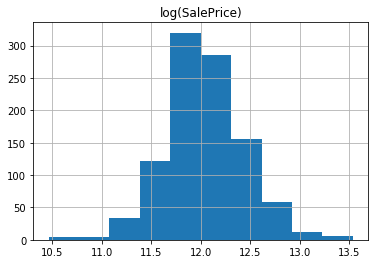

In [27]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

I. Define Ranked Predictions Plot Function

In [28]:
def ranked_preds_plot(y, valid, preds):
    
    """ Generates ranked prediction plot.
    
    :param y: Name of target variable.
    :param valid: Name of validation H2OFrame.
    :param preds: Column vector of predictions to plot.

    """
    
    # plot top frame values
    preds.columns = ['predict']
    yhat_frame = valid.cbind(preds)
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')

J. Define Function to Generate Submission File

In [31]:
import re
import time

def gen_submission(preds, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param preds: Column vector of predictions.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(preds.exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)

K. Define Prediction Blending Function

In [32]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)

N. H2O XGBoost

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1498259532111_14


ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.006249147902781442
RMSE: 0.07905155218451718
MAE: 0.04452643742213597
RMSLE: 0.0061526671615094964
Mean Residual Deviance: 0.006249147902781442

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.018461613204758646
RMSE: 0.13587351914467605
MAE: 0.1051642847996132
RMSLE: 0.010560618933547249
Mean Residual Deviance: 0.018461613204758646

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.017153125537798124
RMSE: 0.13096994135219778
MAE: 0.08812153232204807
RMSLE: 0.010136969402534158
Mean Residual Deviance: 0.017153125537798124
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0880800,0.0016962,0.0847976,0.0889790,0.0904633
mean_residual_deviance,0.0171012,0.0014760,0.0179675,0.0191120,0.0142241
mse,0.0171012,0.0014760,0.0179675,0.0191120,0.0142241
r2,0.8891434,0.0016516,0.8862064,0.8919211,0.8893027
residual_deviance,0.0171012,0.0014760,0.0179675,0.0191120,0.0142241
rmse,0.1305180,0.0057559,0.1340429,0.1382462,0.1192648
rmsle,0.0100965,0.0004909,0.0104083,0.0107469,0.0091344


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2017-06-23 17:30:05,12 min 34.902 sec,0.0,11.5392208,11.5324996,133.1536163,11.5129466,11.5056257,132.5479390
,2017-06-23 17:30:06,12 min 36.540 sec,1.0,11.4819725,11.4752177,131.8356917,11.4557013,11.4483439,131.2330931
,2017-06-23 17:30:06,12 min 36.560 sec,2.0,11.4252392,11.4184509,130.5360912,11.3989712,11.3915771,129.9365437
,2017-06-23 17:30:06,12 min 36.580 sec,3.0,11.3686105,11.3617884,129.2453045,11.3423455,11.3349145,128.6488025
,2017-06-23 17:30:06,12 min 36.600 sec,4.0,11.3123222,11.3054661,127.9686331,11.2860604,11.2785922,127.3751584
---,---,---,---,---,---,---,---,---,---
,2017-06-23 17:34:44,17 min 14.447 sec,4879.0,0.0806099,0.0456638,0.0064980,0.1341500,0.1035046,0.0179962
,2017-06-23 17:34:48,17 min 18.497 sec,4944.0,0.0802204,0.0454222,0.0064353,0.1346284,0.1041173,0.0181248
,2017-06-23 17:34:52,17 min 22.541 sec,5006.0,0.0798129,0.0451062,0.0063701,0.1352055,0.1047045,0.0182805
,2017-06-23 17:34:56,17 min 26.542 sec,5067.0,0.0794222,0.0448352,0.0063079,0.1361481,0.1055130,0.0185363



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
LotFrontage|MoSold,129.0,1.0,0.0047675
MSSubClass|LotFrontage,109.0,0.8449612,0.0040284
MSSubClass|BsmtUnfSF,104.0,0.8062016,0.0038436
LotFrontage|BsmtUnfSF,94.0,0.7286822,0.0034740
TotalBsmtSF|MoSold,92.0,0.7131783,0.0034001
---,---,---,---
BldgType_Tencode|Heating_Tencode,1.0,0.0077519,0.0000370
Exterior2nd_Tencode|Electrical_Tencode,1.0,0.0077519,0.0000370
BsmtFinSF2|TotalBsmtSF,1.0,0.0077519,0.0000370
MSSubClass|GarageQual_Tencode,1.0,0.0077519,0.0000370



See the whole table with table.as_data_frame()

xgboost prediction progress: |████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.034
12.2061,12.2803
11.6784,11.5962
11.7906,11.5897
11.9117,11.8548
11.9767,11.9089
11.8451,11.587
11.1346,11.0992
11.914,11.8051
11.8845,11.8596



xgboost prediction progress: |████████████████████████████████████████████| 100%


FileNotFoundError: [Errno 2] No such file or directory: '../data/submission_Fri_Jun_23_17_35_05_2017.csv'

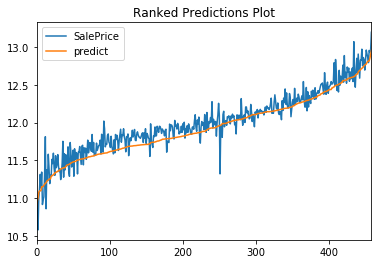

In [34]:
# initialize XGB GBM
h2o_xgb_model = H2OXGBoostEstimator(
    ntrees = 10000,
    learn_rate = 0.005,
    sample_rate = 0.1, 
    col_sample_rate = 0.8,
    max_depth = 5,
    nfolds = 3,
    keep_cross_validation_predictions=True,
    stopping_rounds = 10,
    seed = 12345)

# execute training 
h2o_xgb_model.train(x=encoded_combined_nums,
                    y='SalePrice',
                    training_frame=train,
                    validation_frame=valid)

# print model information/create submission
print(h2o_xgb_model)
h2o_xgb_preds1_val = h2o_xgb_model.predict(valid)
ranked_preds_plot('SalePrice', valid, h2o_xgb_preds1_val) 
h2o_xgb_preds1_test = h2o_xgb_model.predict(test)
gen_submission(h2o_xgb_preds1_test) # 0.16494 on public leaderboard